In [1]:
import numpy as np
import cvxopt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_dataset(N, D=2, K=2):
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels
    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()
    y[y == 0] -= 1
    return X, y

In [17]:
def plot_contour(X, y, svm):
    # plot the resulting classifier
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    Z = svm.predict(points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()

In [25]:
def linear(x, z):
    return np.dot(x, z.T)
def polynomial(x, z, p=5):
    return (1 + np.dot(x, z.T)) ** p
def gaussian(x, z, sigma=0.1):
    return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (sigma ** 2)))
class SVM:
    def __init__(self, kernel=gaussian, C=1):
        self.kernel = kernel
        self.C = C
    def fit(self, X, y):
        self.y = y
        self.X = X
        m, n = X.shape
        # Calculate Kernel
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)
        # Solve with cvxopt final QP needs to be reformulated
        # to match the input form for cvxopt.solvers.qp
        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options["show_progress"] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])
    def predict(self, X):
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_parameters(self.alphas)
        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )
        return np.sign(y_predict + self.b)
    def get_parameters(self, alphas):
        threshold = 1e-5
        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(
            self.y[sv, np.newaxis]
            - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
        )
        return sv

In [18]:
# np.random.seed(1)
# X, y = create_dataset(N=50)

In [20]:
# svm = SVM(kernel=gaussian)
# svm.fit(X, y)
# y_pred = svm.predict(X)
# plot_contour(X, y, svm)

In [21]:
# print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

# svm

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [23]:
class SVM:
    def __init__(self, learning_rate=0.0001, lambda_param=0.001, n_iters=10000):
        self.weights = None
        self.bias =  None
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
    def fit(self,X,y):
        n_samples, n_features = X.shape
        y1 = np.where(y <= 0, -1, 1)
        self.weights = np.zeros(n_features)
        self.bias = 0
        for i in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y1[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights - np.dot(x_i, y1[idx]))
                    self.bias -= self.lr * y1[idx]
    def predict(self, X):
        approx = np.dot(X, self.weights) - self.bias
        return np.sign(approx)

In [24]:
def accuracy(y_true,y_pred):
    acc = np.sum(y_true == y_pred)/len(y_true)
    return acc

In [28]:
X, y =  datasets.make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
y = np.where(y == 0, -1, 1)
clf = SVM()
clf.fit(X_train,y_train)
predict = clf.predict(X_test)
svm_acc = accuracy(y_test,predict)
print('Accuracy:',svm_acc)
print(f'''
     Final Weight:{clf.weights}
     Final Bias:{clf.bias}
     ''')

Accuracy: 0.5333333333333333

     Final Weight:[0.6005085  0.16801693]
     Final Bias:-0.06990000000000098
     


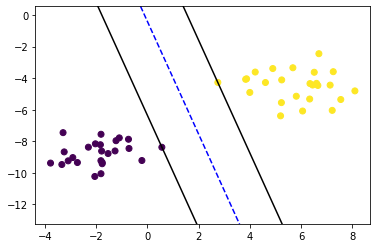

In [27]:
def visualize_svm():
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(X[:,0], X[:,1], marker='o',c=y)
    x0_1 = np.amin(X[:,0])
    x0_2 = np.amax(X[:,0])
    x1_1 = get_hyperplane_value(x0_1, clf.weights, clf.bias, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.weights, clf.bias, 0)
    x1_1_m = get_hyperplane_value(x0_1, clf.weights, clf.bias, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.weights, clf.bias, -1)
    x1_1_p = get_hyperplane_value(x0_1, clf.weights, clf.bias, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.weights, clf.bias, 1)
    ax.plot([x0_1, x0_2],[x1_1, x1_2], 'b--')
    ax.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k')
    ax.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k')
    x1_min = np.amin(X[:,1])
    x1_max = np.amax(X[:,1])
    ax.set_ylim([x1_min-3,x1_max+3])
    plt.show()
visualize_svm() 